# 控制图像的生成

除了配置管道参数之外，还有多种方法可以对图像的生成方式进行更多控制。

In [1]:
from diffusers import AutoPipelineForText2Image
import torch

model_path="/models/stable-diffusion-v1-5"
pipeline = AutoPipelineForText2Image.from_pretrained(
	model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## 提示词的权重

建议使用 [Compel](https://github.com/damian0815/compel) 库来帮助您生成加权提示嵌入。

In [2]:
!pip install compel

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


  0%|          | 0/20 [00:00<?, ?it/s]

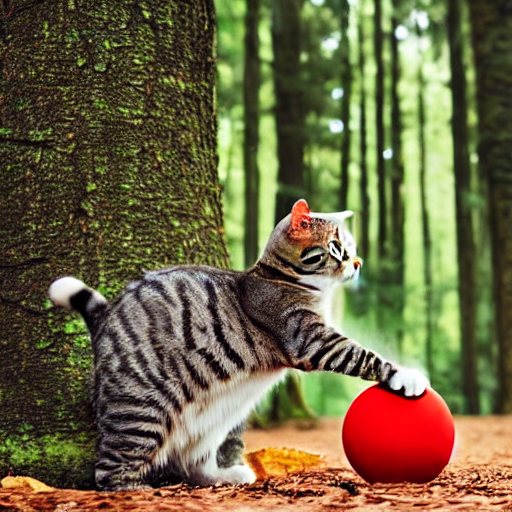

In [3]:
from compel import Compel

compel = Compel(tokenizer=pipeline.tokenizer, text_encoder=pipeline.text_encoder)

# upweight "ball"
prompt = "a cat playing with a ball++ in the forest"
conditioning = compel.build_conditioning_tensor(prompt)
# or: conditioning = compel([prompt])

generator = torch.Generator(device="cuda").manual_seed(100399)

# generate image
images = pipeline(prompt_embeds=conditioning, num_inference_steps=20, generator=generator).images
images[0]

## 使用 ControlNet

模型通过合并额外的调节图像输入，提供了一种更灵活、更准确的生成图像的方法。

比如这是一个姿势的图：

In [5]:
from diffusers import ControlNetModel, AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

controlnet_model_path="/models/control_v11p_sd15_openpose"

controlnet = ControlNetModel.from_pretrained(
	controlnet_model_path, torch_dtype=torch.float16, variant="fp16"
).to("cuda")
pose_image = load_image("./control.png")

  0%|          | 0/50 [00:00<?, ?it/s]

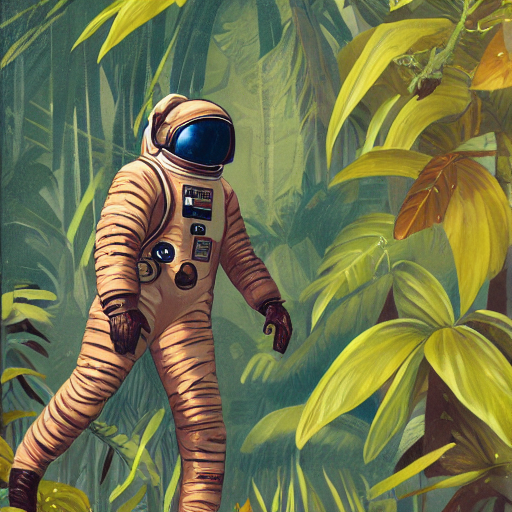

In [6]:
generator = torch.Generator("cuda").manual_seed(31)
image = pipeline("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=pose_image, generator=generator).images[0]
image

In [9]:
!pip install controlnet_aux

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.4/202.4 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 5.0 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 11.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.9/222.9 KB 11.7 MB/s eta 0:00:00
  Created wheel for controlnet_aux: filename=controlnet_aux-0.0.7-py3-none-any.whl size=274356 sha256=7db7f9f9a9560c15d0d7fb652aa4cccd0121dac1b8b179d419fffe742a3828aa
  Stored in directory: /root/.cache/pip/wheels

In [10]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from diffusers.utils import load_image
from PIL import Image
import numpy as np
from controlnet_aux import OpenposeDetector

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)

prompt = "chef in the kitchen"

/usr/local/lib/python3.10/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/usr/local/lib/python3.10/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.

In [12]:
controlnet = ControlNetModel.from_pretrained(controlnet_model_path, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_path, controlnet=controlnet, torch_dtype=torch.float16
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


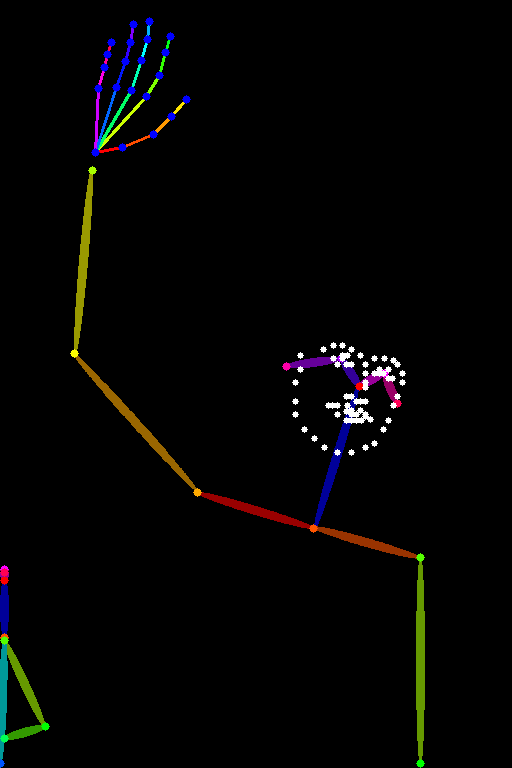

In [14]:
from diffusers.utils import load_image
pose_image = load_image("./control.png")

pose_image

  0%|          | 0/30 [00:00<?, ?it/s]

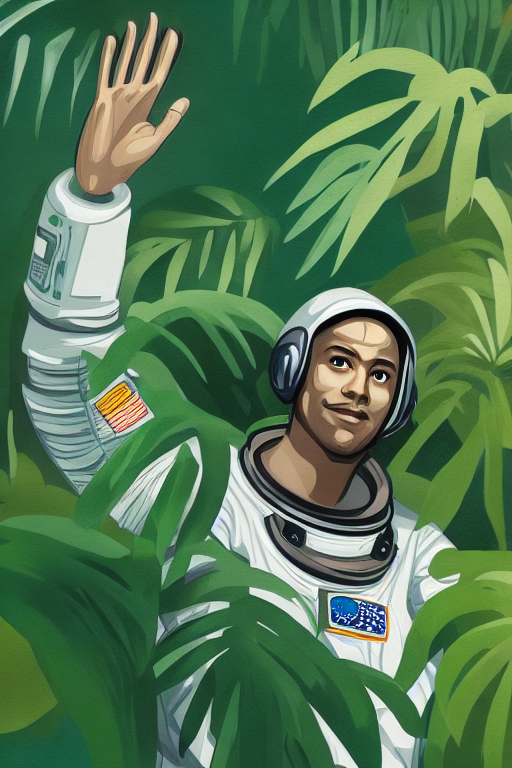

In [18]:


pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

generator = torch.manual_seed(10)
image = pipe("Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", num_inference_steps=30, generator=generator, image=pose_image).images[0]
image